In [ ]:
import pandas as pd

url='https://drive.google.com/file/d/1PsnGFReQGMm861hYFVUx5qjQGchfZGO2/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url)
df.head()

,Fecha_Hora,Events
0,2018-01-01 05:00:00,23
1,2018-01-01 06:00:00,31
2,2018-01-01 07:00:00,49
3,2018-01-01 08:00:00,53
4,2018-01-01 09:00:00,76


In [ ]:
df = df.set_index('Fecha_Hora')
df.index = pd.to_datetime(df.index)

In [ ]:
df.describe()

,Events
count,53989.000000
mean,772.148641
std,948.691461
min,0.000000
25%,13.000000
50%,451.000000
75%,1122.000000
max,7531.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53989 entries, 2018-01-01 05:00:00 to 2024-02-29 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Events  53989 non-null  int64
dtypes: int64(1)
memory usage: 843.6 KB


In [ ]:
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = df.set_index('Fecha_Hora')
df.index = pd.to_datetime(df.index)

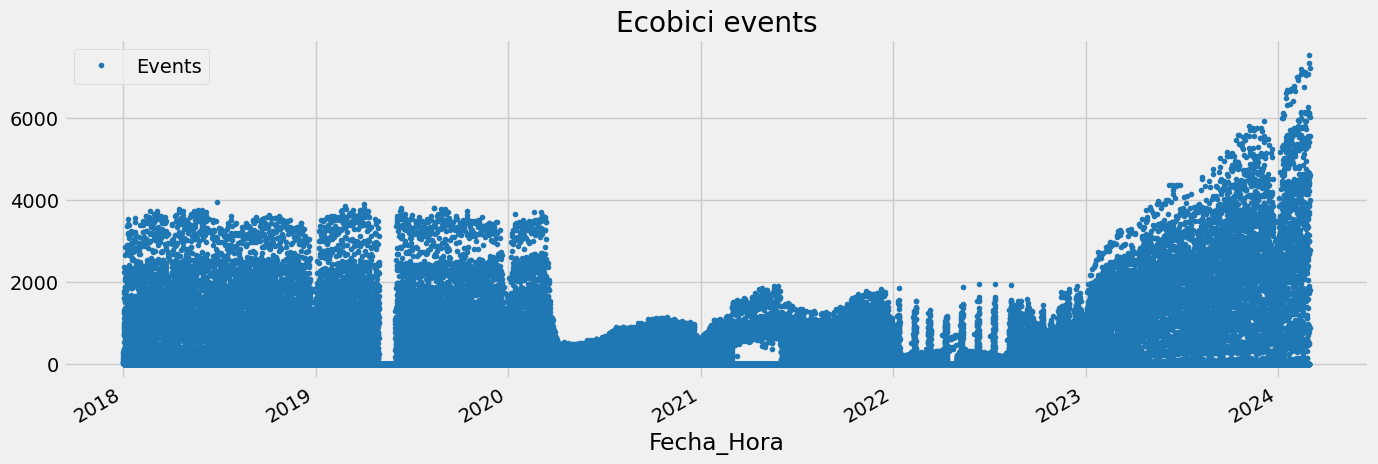

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Ecobici events')
plt.show()

# Train / Test Split

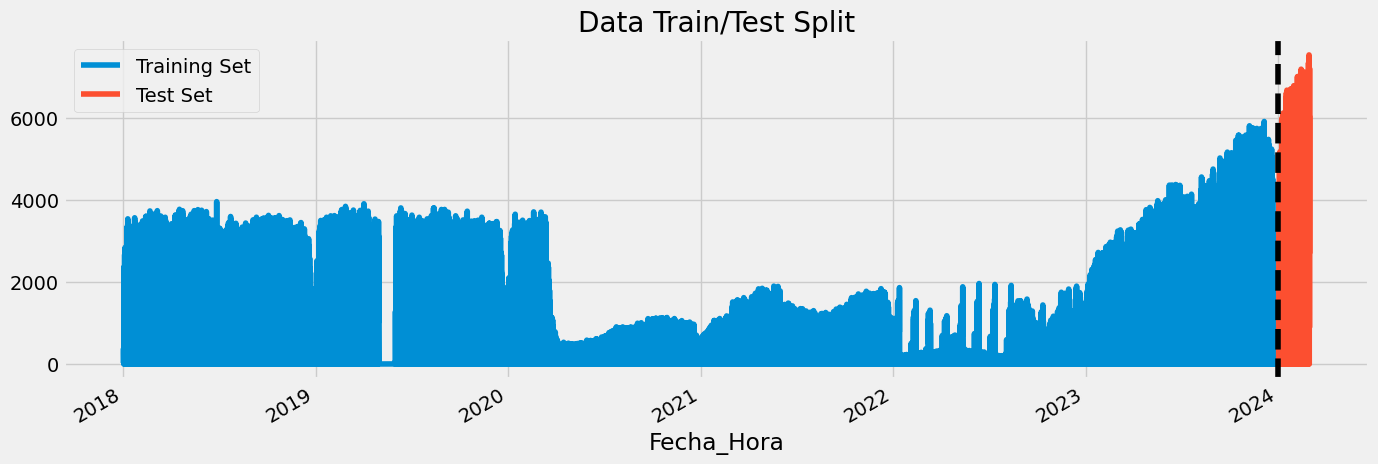

In [ ]:
train = df.loc[df.index < '01-01-2024']
test = df.loc[df.index >= '01-02-2024']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2024', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

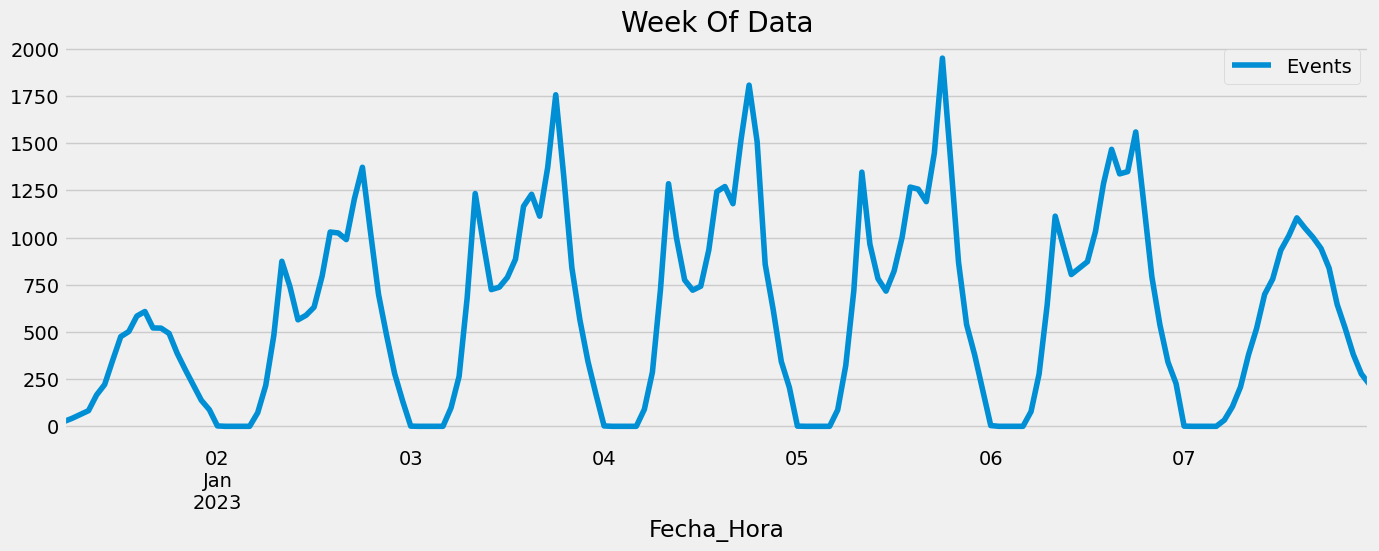

In [ ]:
df.loc[(df.index > '01-01-2023') & (df.index < '01-08-2023')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Visualize our Feature / Target Relationship

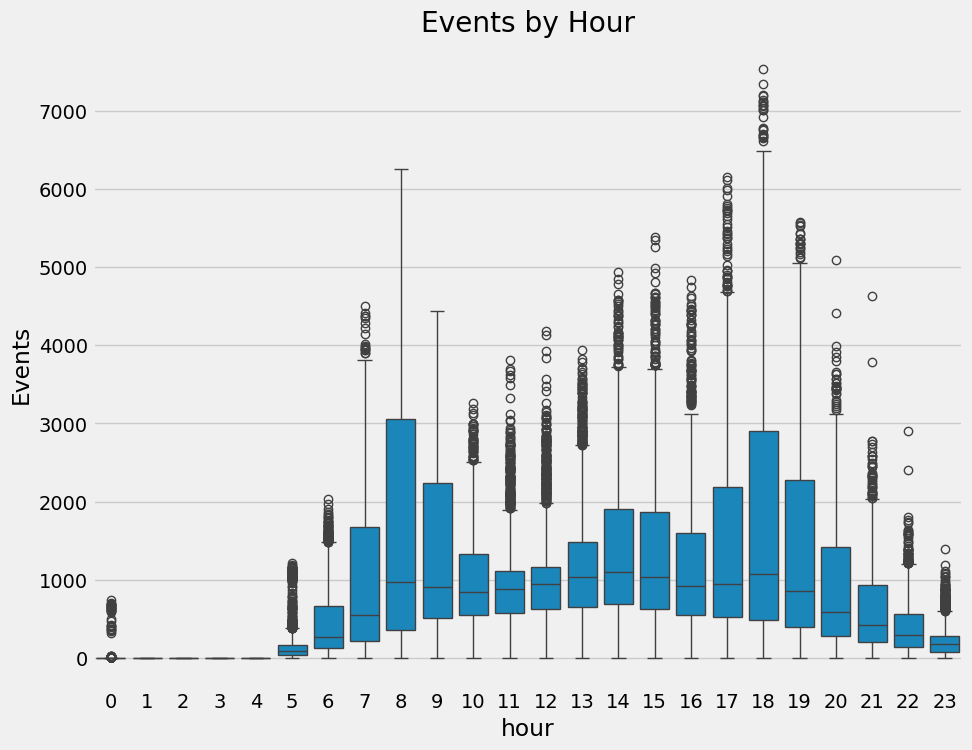

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Events')
ax.set_title('Events by Hour')
plt.show()

/tmp/ipykernel_263/4211354742.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Events', palette='Blues')


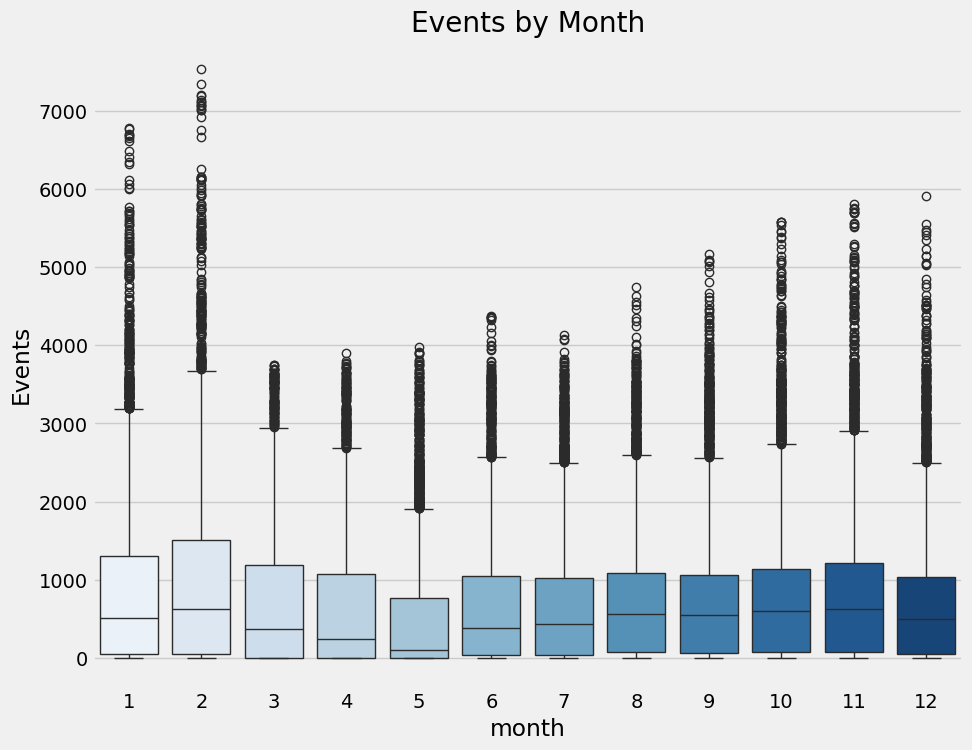

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Events', palette='Blues')
ax.set_title('Events by Month')
plt.show()

# Create our Model

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Events'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1133.31490	validation_1-rmse:2924.93047
/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:52:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
[100]	validation_0-rmse:681.41223	validation_1-rmse:2136.95414
[200]	validation_0-rmse:548.11673	validation_1-rmse:1881.90225
[300]	validation_0-rmse:496.97248	validation_1-rmse:1794.87780
[400]	validation_0-rmse:469.61671	validation_1-rmse:1764.26697
[500]	validation_0-rmse:452.44048	validation_1-rmse:1751.43193
[600]	validation_0-rmse:438.51971	validation_1-rmse:1746.39347
[700]	validation_0-rmse:424.97132	validation_1-rmse:1740.86837
[783]	validation_0-rmse:417.37778	validation_1-rmse:1739.26976


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

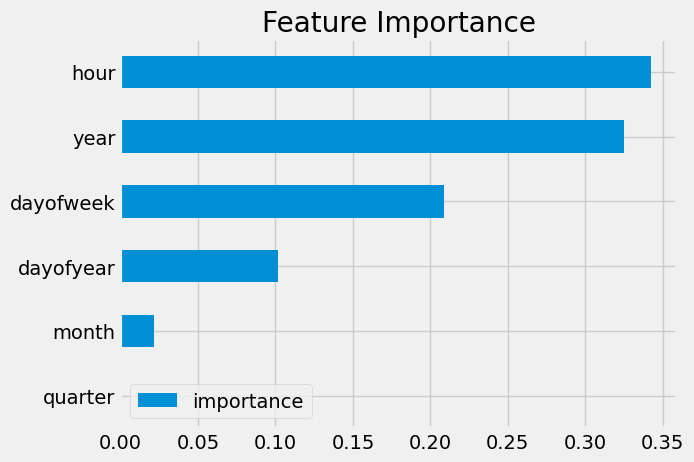

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

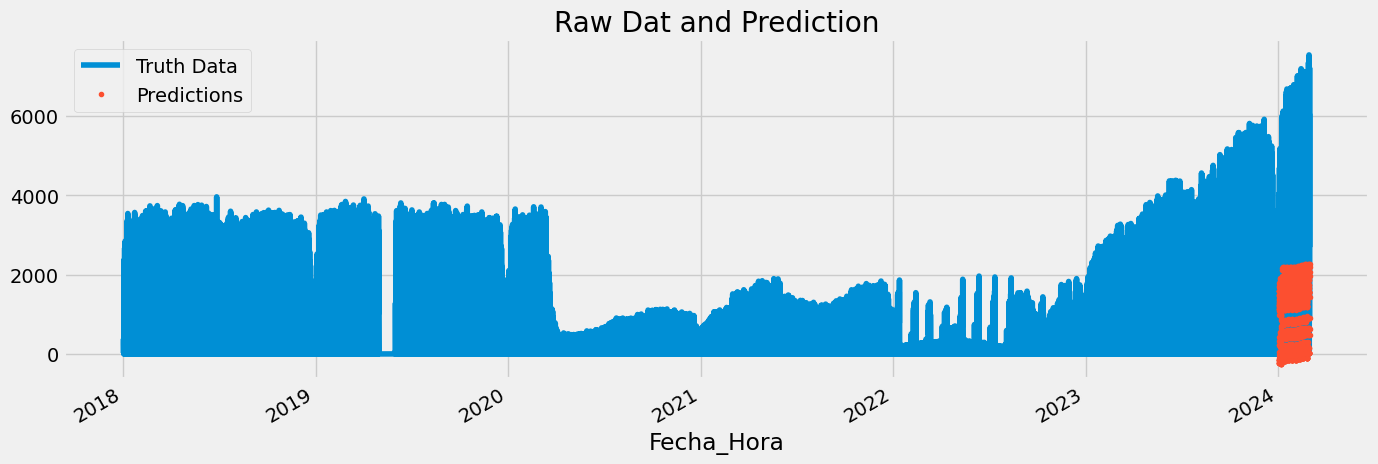

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Events']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

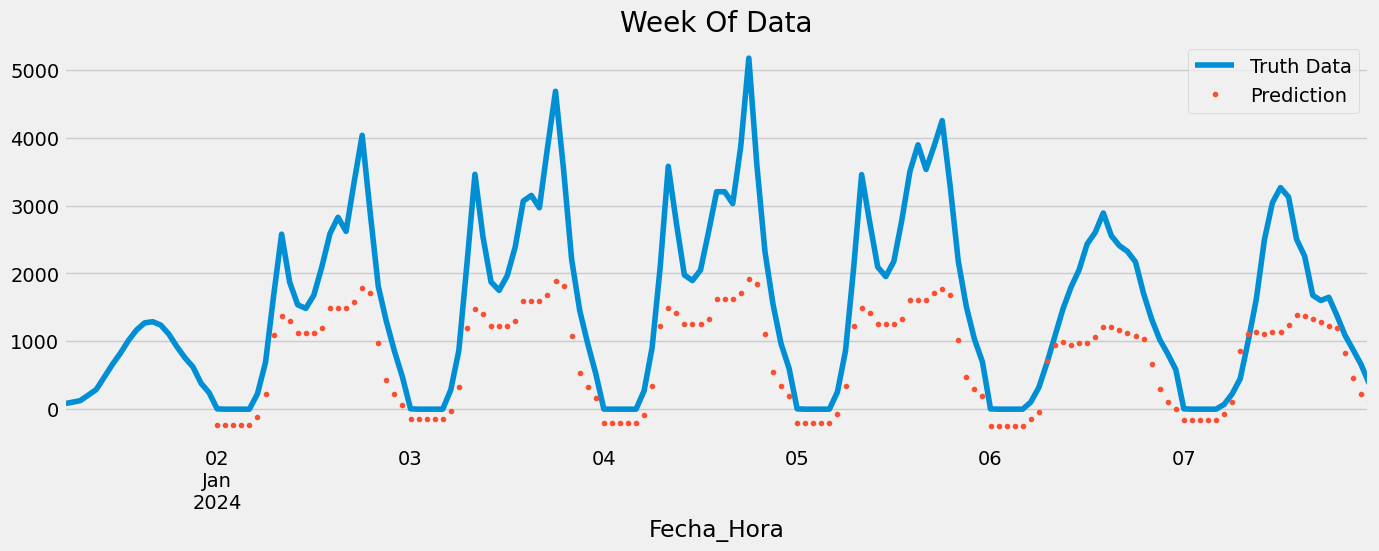

In [ ]:
ax = df.loc[(df.index > '01-01-2024') & (df.index < '01-08-2024')]['Events'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2024') & (df.index < '01-08-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['Events'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1738.10


## Calculate Error

Look at the worst and best predicted days


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-02-28    1834.950109
2024-02-29    1809.241776
2024-02-27    1794.200109
2024-02-13    1772.483108
2024-02-20    1719.533442
2024-02-22    1718.908442
2024-02-14    1714.233108
2024-02-21    1706.700109
2024-02-07    1666.691873
2024-02-15    1664.983108
Name: error, dtype: float64

# New training

In [ ]:
df = df.loc[df.index >= '01-02-2023']
df

,Events
Fecha_Hora,
2023-01-02 00:00:00,2
2023-01-02 01:00:00,0
2023-01-02 02:00:00,0
2023-01-02 03:00:00,0
2023-01-02 04:00:00,0
...,...
2024-02-29 19:00:00,5557
2024-02-29 20:00:00,3990
2024-02-29 21:00:00,2782


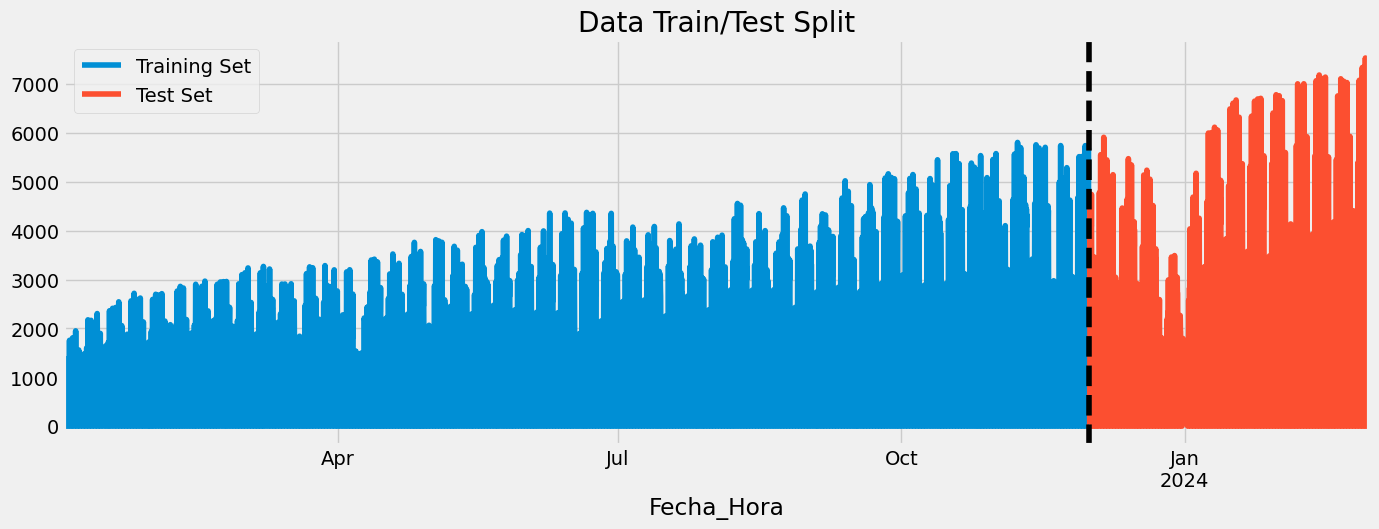

In [ ]:
train = df.loc[(df.index >= '01-01-2023') & (df.index < '12-01-2023')]
test = df.loc[df.index >= '12-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('12-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Create model

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Events'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       early_stopping_rounds=500,
                       objective='reg:linear',
                       max_depth=30,
                       learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1628.66294	validation_1-rmse:2542.14750
/root/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:11:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
[100]	validation_0-rmse:2.64317	validation_1-rmse:1501.34881
[200]	validation_0-rmse:0.01668	validation_1-rmse:1501.19392
[300]	validation_0-rmse:0.00137	validation_1-rmse:1501.19330
[400]	validation_0-rmse:0.00134	validation_1-rmse:1501.19339
[500]	validation_0-rmse:0.00134	validation_1-rmse:1501.19347
[600]	validation_0-rmse:0.00134	validation_1-rmse:1501.19356
[700]	validation_0-rmse:0.00134	validation_1-rmse:1501.19365
[755]	validation_0-rmse:0.00134	validation_1-rmse:1501.19370


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Forecast Test

In [ ]:
# del df['prediction_x']
# del df['prediction_y']
# del df['prediction']

df

,Events,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Fecha_Hora,,,,,,,,,
2023-01-02 00:00:00,2,0,0,1,1,2023,2,2,1
2023-01-02 01:00:00,0,1,0,1,1,2023,2,2,1
2023-01-02 02:00:00,0,2,0,1,1,2023,2,2,1
2023-01-02 03:00:00,0,3,0,1,1,2023,2,2,1
2023-01-02 04:00:00,0,4,0,1,1,2023,2,2,1
...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,5557,19,3,1,2,2024,60,29,9
2024-02-29 20:00:00,3990,20,3,1,2,2024,60,29,9
2024-02-29 21:00:00,2782,21,3,1,2,2024,60,29,9


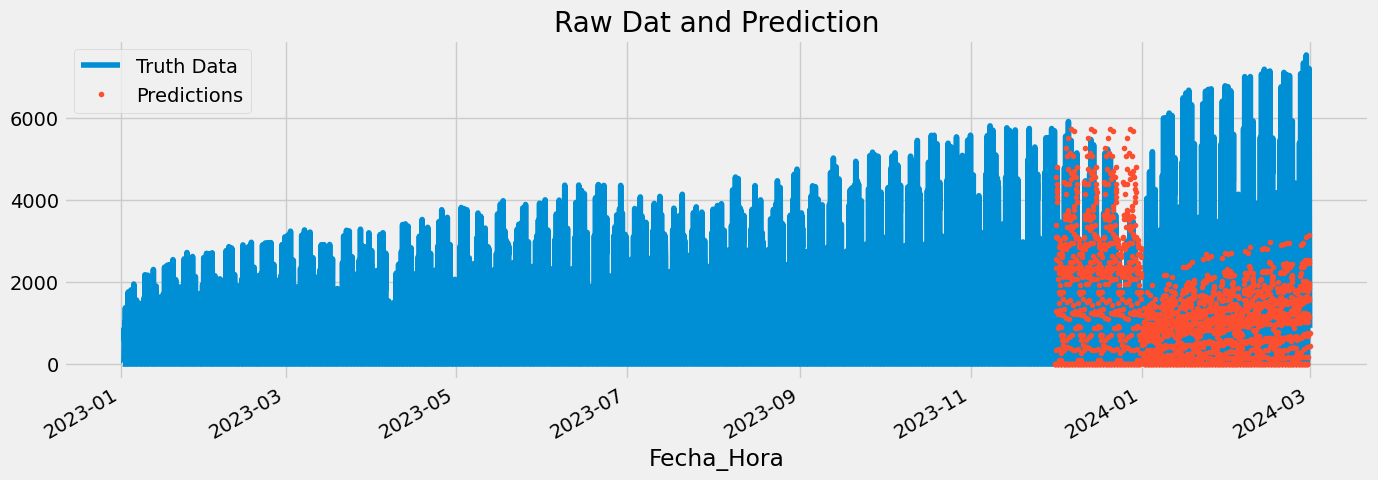

In [ ]:
test['prediction'] = reg.predict(X_test).copy()
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Events']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

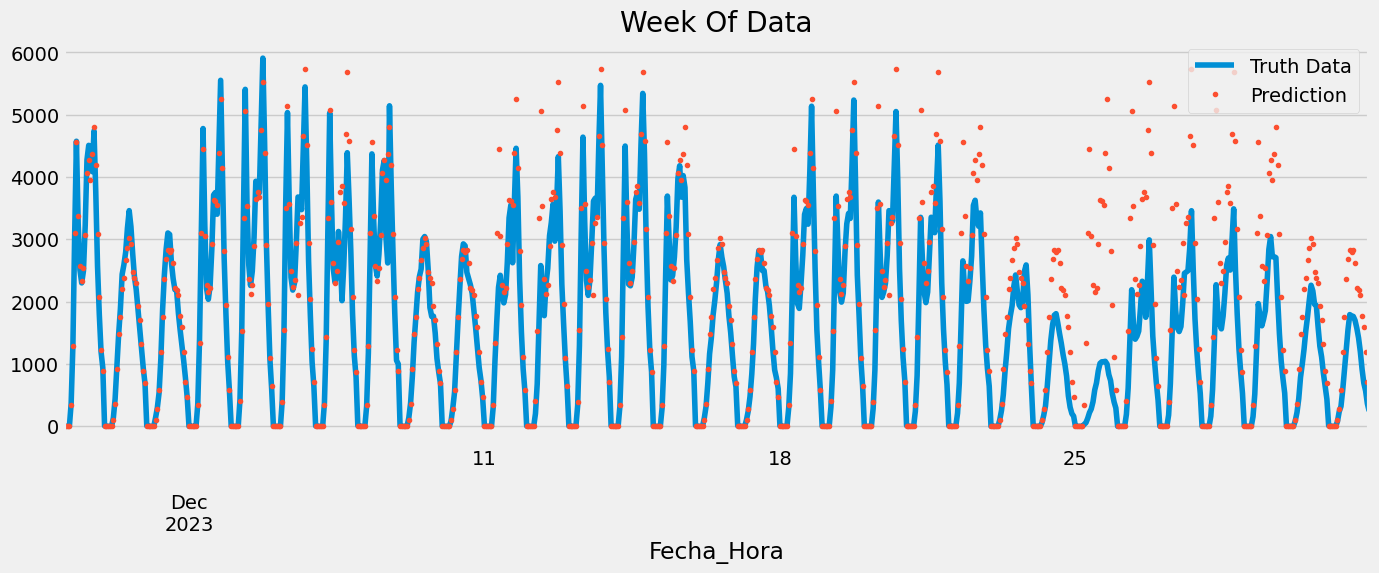

In [ ]:
ax = df.loc[(df.index > '12-01-2023') & (df.index < '01-01-2024')]['Events'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '12-01-2023') & (df.index < '01-01-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

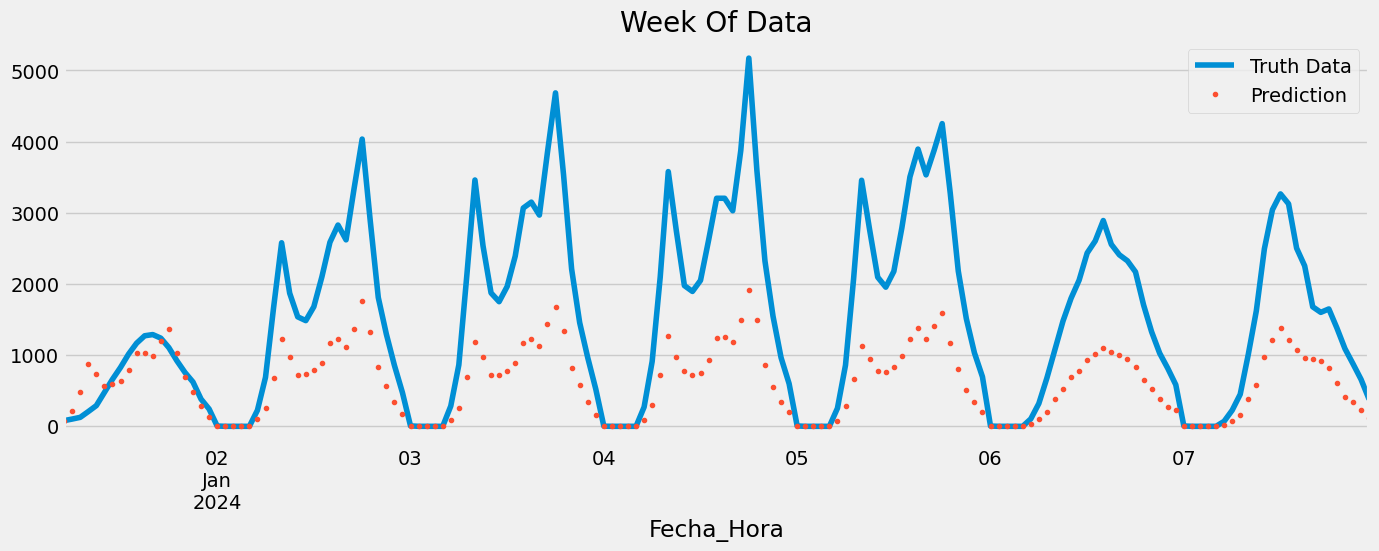

In [ ]:
ax = df.loc[(df.index > '01-01-2024') & (df.index < '01-08-2024')]['Events'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2024') & (df.index < '01-08-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25df4652-e935-424f-95eb-02091fa21a09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>